# Практика: word2vec для кристаллов

Как вы уже могли заметить, идея, лежащая в основе [word2vec](https://arxiv.org/pdf/1310.4546), достаточно общая. В данном задании вы реализуете его самостоятельно.

P.s. GPU в этом задании нам не потребуется :)

Многие функции из этого ноутбука лежат в файле `skipgram_model_functions.py`. Это сделано специально, чтобы подсветить важные моменты и не отвлекаться на большое количество кода. Мы рекомендуем ничего не менять в функциях, исключением могут быть функции для визуализации данных.

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import umap
from nltk.tokenize import WhitespaceTokenizer
from nltk.tokenize import PunktSentenceTokenizer
from nltk.tokenize import RegexpTokenizer
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR

from skipgram_model_functions import *

2024-12-10 18:14:04.802155: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-10 18:14:05.251109: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-10 18:14:05.251160: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-10 18:14:05.253356: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-10 18:14:05.425561: I tensorflow/core/platform/cpu_feature_g

## Что мы хотим сделать?

Это задание нужно для того, чтобы своими руками написать модель, которая является отправной точкой для современных LLM. Прежде чем углубляться в более сложные архитектуры и изучать то, как LLM на лету генерирует текст (а иногда и не текст, а что-то другой модальности), что можно считать работой с последовательностями динамической длины, мы хотим разобраться с построением контекстуального эмбеддинга для токена - атомарной единицы языка. Мы будем решать задачу предсказания вероятности одного токена оказаться (или не оказаться) в одном контексте с другим. Из этого знания мы можем получить представление о том, какие токены схожи и различны. Опираясь на эту информацию можно не только приступать к генерации последовательностей, но и решать другие задачи. Например, в кристаллохимии можно предсказывать физикохимические свойства соединений, зная их векторное представление, или эмбеддинг.

## Небольшой рассказ о данных

Мы будем работать с базой данных `Materials Project`. Для задачи были отобраны стабильные экспериментальные кристаллические структуры, для которых было сгенерировано текстовое описние при помощи `Robocrystallographer`. Все текстовые описания были токенизированы (в нашем случае токен = 1 слово). В `корпус` попали те структуры, описание которых не превышало 70 токенов. 
<p>Папка содержит 2 файла с данными:

`robocrys_exp_stable_70_tokens.txt` - основной файл, с которым мы будем работать. Содержит строки с текстовым описанием кристаллических структур.
<p>

`robocrys_exp_stable_70_tokens.csv` - файл, содержащий дополнительную информацию о кристаллических структурах, которая пригодится при визуализации эмбеддингов, которые мы посчитаем

In [2]:
data = list(open("robocrys_exp_stable_70_tokens.txt", encoding="utf-8"))

## Предобработка данных. Токенизация

Токенизация – первый шаг.
Тексты, с которыми мы работаем, включают в себя пунктуацию и прочие нестандартные токены, так что простой `str.split` иногда может не подходить под конкретную задачу. В данном случае в качестве токена мы будем использовать каждое слово, число и символ пространнственной группы. Можно было бы для каждой строки `i` в `data` выполнить `data[i].strip().split()`, но мы используем `WhitespaceTokenizer`, выполняющий аналогичную функцию.

Обратимся к `nltk` - библиотеке, которая нашла широкое применение в области NLP.

In [3]:
tokenizer = WhitespaceTokenizer()
tokenizer2 = RegexpTokenizer(r'\w+|\S+')

Посмотрим, как выглядит типичное описание одного кристалла:

In [4]:
test_description = data[0]

print(test_description)

Hf is Magnesium structured and crystallizes in the hexagonal P63/mmc space group. Hf is bonded to twelve equivalent Hf atoms to form a mixture of edge, face, and corner-sharing HfHf12 cuboctahedra. There are six shorter (3.12 Å) and six longer (3.19 Å) Hf-Hf bond lengths.



Можно заметить, что описание содержит переносы строки, запятые и точки, которые необходимо удалить перед применением `WhitespaceTokenizer`. Все точки удалять нельзя, потому что некоторые из них являются частью чисел с плавающей точкой (например, 3.26 Å). Также нельзя удалять и использовать в качестве разделителей для токенизации некоторые специальные символы: /, -.

Сначала заменим все запятые в описаниях кристаллов на пробелы:

In [42]:
test_description = test_description.replace(",", "").replace('(', '').replace(')', '').replace('-', ' - ')

print(test_description)

Hf is Magnesium structured and crystallizes in the hexagonal P63/mmc space group. Hf is bonded to twelve equivalent Hf atoms to form a mixture of edge face and corner  -  sharing HfHf12 cuboctahedra. There are six shorter  3.12 Å  and six longer  3.19 Å  Hf  -  Hf bond lengths.



Теперь необходимо избавиться от символов переноса строки и точек в конце каждого предложения. Для этого используем `PunktSentenceTokenizer`. Он разобьёт описания на предложения, а затем мы удалим точку в конце каждого из них.

In [6]:
print(tokenizer2.tokenize(test_description))

['Hf', 'is', 'Magnesium', 'structured', 'and', 'crystallizes', 'in', 'the', 'hexagonal', 'P63', '/mmc', 'space', 'group', '.', 'Hf', 'is', 'bonded', 'to', 'twelve', 'equivalent', 'Hf', 'atoms', 'to', 'form', 'a', 'mixture', 'of', 'edge', 'face', 'and', 'corner', '-', 'sharing', 'HfHf12', 'cuboctahedra', '.', 'There', 'are', 'six', 'shorter', '(', '3', '.12', 'Å', ')', 'and', 'six', 'longer', '(', '3', '.19', 'Å', ')', 'Hf', '-', 'Hf', 'bond', 'lengths', '.']


In [7]:
sentence_tokenizer = PunktSentenceTokenizer()
 

In [43]:
test_sentences = sentence_tokenizer.tokenize(test_description)

print(f'Test sentences in description look like:\n{test_sentences}')


# Вот теперь используем WhiteSpaceTokenizer
sentences_modified = [s.rstrip('.') for s in test_sentences]
test_tokens = sum([tokenizer.tokenize(sentence) for sentence in sentences_modified], [])

print(f'Test tokens of description look like:\n{test_tokens}')

Test sentences in description look like:
['Hf is Magnesium structured and crystallizes in the hexagonal P63/mmc space group.', 'Hf is bonded to twelve equivalent Hf atoms to form a mixture of edge face and corner  -  sharing HfHf12 cuboctahedra.', 'There are six shorter  3.12 Å  and six longer  3.19 Å  Hf  -  Hf bond lengths.']
Test tokens of description look like:
['Hf', 'is', 'Magnesium', 'structured', 'and', 'crystallizes', 'in', 'the', 'hexagonal', 'P63/mmc', 'space', 'group', 'Hf', 'is', 'bonded', 'to', 'twelve', 'equivalent', 'Hf', 'atoms', 'to', 'form', 'a', 'mixture', 'of', 'edge', 'face', 'and', 'corner', '-', 'sharing', 'HfHf12', 'cuboctahedra', 'There', 'are', 'six', 'shorter', '3.12', 'Å', 'and', 'six', 'longer', '3.19', 'Å', 'Hf', '-', 'Hf', 'bond', 'lengths']


Теперь токенизируем все описания кристаллов в нашем корпусе:

In [23]:
data_tokenized = []

for description in data:
    description = description.replace(",", "").replace(' (', '').replace(') ', '').replace('-', ' - ')
    sentences = sentence_tokenizer.tokenize(description)
    sentences_modified = [s.rstrip('.') for s in sentences]
    tokens = sum([tokenizer.tokenize(s) for s in sentences_modified], [])
    data_tokenized.append(tokens)


print(f"Количество описаний кристаллов в корпусе:\n{len(data_tokenized)}\n")

n_tokens = sum(len(description) for description in data_tokenized)
print(f"Суммарное количество токенов в корпусе:\n{n_tokens}")

Количество описаний кристаллов в корпусе:
1798

Суммарное количество токенов в корпусе:
120120


## Частота встречаемости слов и уникальные слова

Для расчета вероятностей нахождения одного слова в контексте другого нам необходимо получить частоту встречаемости каждого токена и список уникальных токенов. Сначала подсчитаем частоту встречаемости слов в корпусе:

In [24]:
word_count_dict = get_word_count_dict(data_tokenized)

Получим множество уникальных токенов. Это множество будет нашим `словарём`

In [25]:
vocabulary = set(word_count_dict.keys())


print(f'Количество уникальных токенов в корпусе:\n{len(vocabulary)}')

Количество уникальных токенов в корпусе:
4122


Индексируем наш словарь:

In [26]:
word_to_index = {word: index for index, word in enumerate(vocabulary)}
index_to_word = {index: word for word, index in word_to_index.items()}

## Создание пар `(слово, контекст)`

Для построения пар `(слово, контекст)` нам необходимо пройтись скользящим окном по всем описаниям в нашем корпусе.

Ниже задана ширина окна контекста Skipgram модели.

In [27]:
window_radius = 9

Пары `(слово, контекст)` на основе доступного датасета сгенерированы ниже.

In [28]:
context_pairs = get_context_pairs(data_tokenized, word_to_index, window_radius)

print(f"Количество пар (слово, контекст): {len(context_pairs)}")

Количество пар (слово, контекст): 1896402


## Подзадача №1: subsampling
Для того, чтобы сгладить разницу в частоте встречаемсости слов, необходимо реализовать механизм subsampling'а.
Для этого вам необходимо реализовать функцию ниже.

Вероятность **исключить** слово из обучения (на фиксированном шаге) вычисляется как
$$
P_\text{drop}(w_i)=1 - \sqrt{\frac{t}{f(w_i)}},
$$
где $f(w_i)$ – нормированная частота встречаемости слова, а $t$ – заданный порог (threshold).

In [29]:
def subsample_frequent_words(word_count_dict, threshold=1e-5):
    """
    Calculates the subsampling probabilities for words based on their frequencies.

    This function is used to determine the probability of keeping a word in the dataset
    when subsampling frequent words. The method used is inspired by the subsampling approach
    in Word2Vec, where each word's frequency affects its probability of being kept.

    Parameters:
    - word_count_dict (dict): A dictionary where keys are words and values are the counts of those words.
    - threshold (float, optional): A threshold parameter used to adjust the frequency of word subsampling.
                                   Defaults to 1e-5.

    Returns:
    - dict: A dictionary where keys are words and values are the probabilities of keeping each word.

    """

    words_count = sum(word_count_dict.values())

    keep_prob_dict = {}  

    for word, count in word_count_dict.items():

        freq_norm = count / words_count
        include_prob = (threshold / freq_norm) ** 0.5 if freq_norm > threshold else 0
        keep_prob_dict[word] = include_prob
        
    return keep_prob_dict

## Подзадача №2: negative sampling
Для более эффективного обучения необходимо не только предсказывать высокие вероятности для слов из контекста, но и предсказывать низкие для слов, не встреченных в контексте. Для этого вам необходимо вычислить вероятность использовать слово в качестве negative sample, реализовав функцию ниже.

`ВНИМАНИЕ: этот код вам нужно написать самостоятельно`

В оригинальной статье предлагается оценивать вероятность слов выступать в качестве negative sample согласно распределению $P_n(w)$
$$
P_n(w) = \frac{U(w)^{3/4}}{Z},
$$

где $U(w)$ распределение слов по частоте (или, как его еще называют, по униграммам), а $Z$ – нормировочная константа, чтобы общая мера была равна $1$.

`ПОДСКАЗКА`: распределение слов по частоте есть ничто иное как частота встречаемости слова в корпусе

In [30]:
def get_negative_sampling_prob(word_count_dict):
    """
    Calculates the negative sampling probabilities for words based on their frequencies.

    This function adjusts the frequency of each word raised to the power of 0.75, which is
    commonly used in algorithms like Word2Vec to moderate the influence of very frequent words.
    It then normalizes these adjusted frequencies to ensure they sum to 1, forming a probability
    distribution used for negative sampling.

    Parameters:
    - word_count_dict (dict): A dictionary where keys are words and values are the counts of those words.

    Returns:
    - dict: A dictionary where keys are words and values are the probabilities of selecting each word
            for negative sampling.

    """
    
    words_count = sum(word_count_dict.values())
    negative_sampling_prob_dict = {}  
    
    Z = 0
    negative_probs = []   
    for word, count in word_count_dict.items():

        U = count / words_count
        negative_prob = U ** (3 / 4)
        Z += negative_prob
        negative_probs.append(negative_prob)
    for word, count in word_count_dict.items(): negative_sampling_prob_dict[word] = (count / words_count) ** (3/4) / Z
    



    return negative_sampling_prob_dict

Применим функции `subsample_frequent_words` для расчета вероятностей слов быть отобранными в обучающую выборку и `get_negative_sampling_prob` для расчета вероятностей слов быть отобранными в выборку negative_sampling.<p>
Для удобства, преобразуем полученные словари в массивы (т.к. все слова все равно уже пронумерованы).

In [31]:
keep_prob_dict = subsample_frequent_words(word_count_dict)
assert keep_prob_dict.keys() == word_count_dict.keys()

keep_prob_array = keep_prob_to_array(keep_prob_dict, index_to_word, word_to_index)

In [32]:
negative_sampling_prob_dict = get_negative_sampling_prob(word_count_dict)
assert np.allclose(sum(negative_sampling_prob_dict.values()), 1)

negative_sampling_prob_array = negative_sampling_prob_to_array(negative_sampling_prob_dict, index_to_word, word_to_index)

### Реализация модели Skipgram

Наконец, время реализовать модель!

Напомним, что в случае negative sampling решается задача максимизации следующего функционала:

$$
\mathcal{L} = \log \sigma({\mathbf{v}'_{w_O}}^\top \mathbf{v}_{w_I}) + \sum_{i=1}^{k} \mathbb{E}_{w_i \sim P_n(w)} \left[ \log \sigma({-\mathbf{v}'_{w_i}}^\top \mathbf{v}_{w_I}) \right],
$$

где:
- $\mathbf{v}_{w_I}$ – вектор центрального слова $w_I$,
- $\mathbf{v}'_{w_O}$ – вектор слова из контекста $w_O$,
- $k$ – число negative samples,
- $P_n(w)$ – распределение negative samples, заданное выше,
- $\sigma$ – сигмоида.

In [33]:
class SkipGramModelWithNegSampling(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        self.center_embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.context_embeddings = nn.Embedding(vocab_size, embedding_dim)

    def forward(self, center_words, pos_context_words, neg_context_words):

        center_embeddings = self.center_embeddings(center_words)
        pos_context_embeddings = self.context_embeddings(pos_context_words)
        neg_context_embeddings = self.context_embeddings(neg_context_words)

        pos_scores = torch.sum(center_embeddings * pos_context_embeddings, dim=1)
        neg_scores = torch.sum((center_embeddings.unsqueeze(1) * neg_context_embeddings), dim = 2)

        return pos_scores, neg_scores

## Обучаем модель

Инициализируем модель. Не забываем инициализировать её перед каждым обучением!

In [34]:
device = torch.device("cpu")

vocab_size = len(word_to_index)
embedding_dim = 32
num_negatives = 15

model = SkipGramModelWithNegSampling(vocab_size, embedding_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.05)
lr_scheduler = ReduceLROnPlateau(optimizer, factor=0.5, patience=150)
criterion = nn.BCEWithLogitsLoss()

params_counter = 0
for weights in model.parameters():
    params_counter += weights.shape.numel()
assert params_counter == len(word_to_index) * embedding_dim * 2

Запускаем обучение:

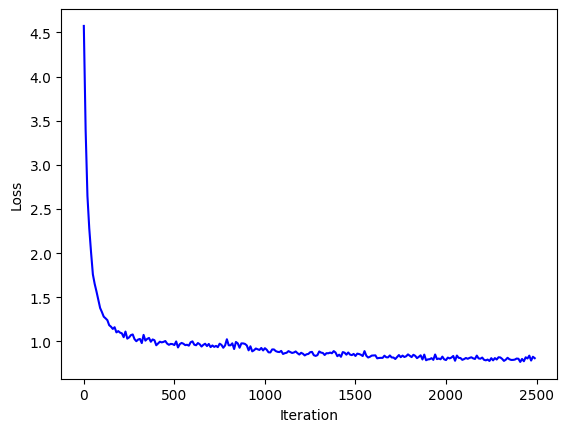

In [21]:
steps = 2500
batch_size = 1024

train_skipgram_with_neg_sampling(
    model,
    context_pairs,
    keep_prob_array,
    word_to_index,
    batch_size,
    num_negatives,
    negative_sampling_prob_array,
    steps,
    optimizer=optimizer,
    lr_scheduler=lr_scheduler,
    device=device,
)

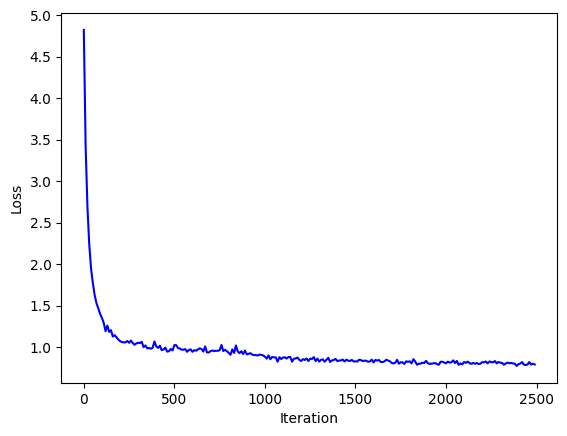

In [36]:
steps = 2500
batch_size = 1024

train_skipgram_with_neg_sampling(
    model,
    context_pairs,
    keep_prob_array,
    word_to_index,
    batch_size,
    num_negatives,
    negative_sampling_prob_array,
    steps,
    optimizer=optimizer,
    lr_scheduler=lr_scheduler,
    device=device,
)

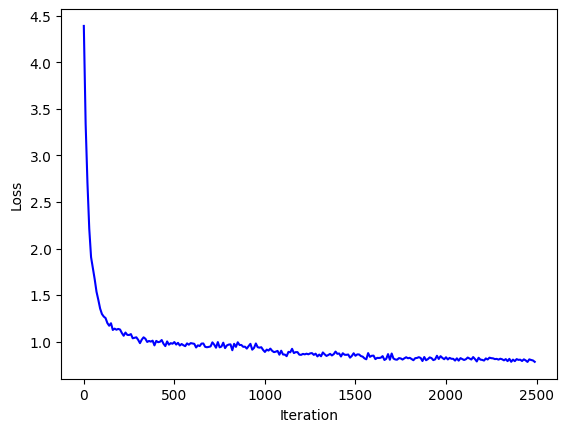

In [68]:
steps = 2500
batch_size = 1024

train_skipgram_with_neg_sampling(
    model,
    context_pairs,
    keep_prob_array,
    word_to_index,
    batch_size,
    num_negatives,
    negative_sampling_prob_array,
    steps,
    optimizer=optimizer,
    lr_scheduler=lr_scheduler,
    device=device,
)

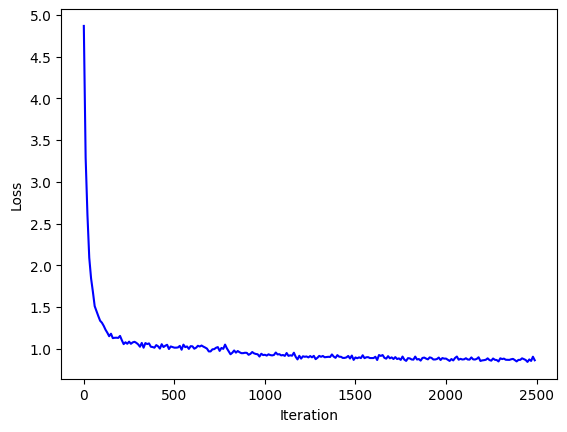

In [35]:
steps = 2500
batch_size = 1024

train_skipgram_with_neg_sampling(
    model,
    context_pairs,
    keep_prob_array,
    word_to_index,
    batch_size,
    num_negatives,
    negative_sampling_prob_array,
    steps,
    optimizer=optimizer,
    lr_scheduler=lr_scheduler,
    device=device,
)

Сохраняем состояние обученной модельки:

In [35]:
torch.save(model.state_dict(), 'my_model_100_test.pth')

In [32]:
model = SkipGramModelWithNegSampling(vocab_size, embedding_dim)
model.load_state_dict(torch.load('my_model_100_test.pth'))
model.eval()

SkipGramModelWithNegSampling(
  (center_embeddings): Embedding(5620, 32)
  (context_embeddings): Embedding(5620, 32)
)

## Тестируем модель

Оценим Accuracy модели:

In [ ]:
accuracy = evaluate_model(model, context_pairs, device) # Исходное

Evaluating: 100%|██████████| 25456/25456 [00:03<00:00, 6769.56it/s]


Accuracy: 0.8141


In [ ]:
accuracy = evaluate_model(model, context_pairs, device) # Загрузил модель из .pth

Evaluating: 100%|██████████| 25456/25456 [00:03<00:00, 6405.14it/s]


Accuracy: 0.4370


In [ ]:
accuracy = evaluate_model(model, context_pairs, device) # Обучил заново

Evaluating: 100%|██████████| 25456/25456 [00:03<00:00, 6961.04it/s]


Accuracy: 0.8167


In [ ]:
accuracy = evaluate_model(model, context_pairs, device) # Обучил, возможно, опять заново (уже не помню почему)

Evaluating: 100%|██████████| 25456/25456 [00:04<00:00, 5490.42it/s]


Accuracy: 0.8144


In [ ]:
accuracy = evaluate_model(model, context_pairs, device) # Поменял токены так, чтобы '(', ')' и '-' считались отдельными

Evaluating: 100%|██████████| 30284/30284 [00:02<00:00, 11344.24it/s]


Accuracy: 0.8105


In [ ]:
accuracy = evaluate_model(model, context_pairs, device) # Удалил скобки () и отделил '-'

Evaluating: 100%|██████████| 29632/29632 [00:02<00:00, 12595.43it/s]


Accuracy: 0.8127


Наконец, взглянем на ближайшие по косинусной мере слова:

In [23]:
central_word = "He"
n_neighbours = 20

find_nearest(model, central_word, word_to_index, index_to_word, n_neighbours)

[('ErCd', 0.6606431603431702),
 ('each', 0.6664037108421326),
 ('NO2', 0.6699904203414917),
 ('K-N', 0.6708511114120483),
 ('Ne', 0.6723001003265381),
 ('thirty-two', 0.6741820573806763),
 ('1.70', 0.6772388219833374),
 ('MgB2', 0.6779054403305054),
 ('Cl2', 0.6856948137283325),
 ('Cl-Cl', 0.6891703009605408),
 ('PtAl', 0.689933180809021),
 ('SBr', 0.6981358528137207),
 ('YAu', 0.7041060924530029),
 ('S6+', 0.7096752524375916),
 ('IrY', 0.7195654511451721),
 ('2.90-3.15', 0.7585922479629517),
 ('XeF2', 0.78639155626297),
 ('BH', 0.8065178394317627),
 ('CO2', 0.831089973449707),
 ('He', 0.9999998807907104)]

In [34]:
central_word = "He"
n_neighbours = 20

find_nearest(model, central_word, word_to_index, index_to_word, n_neighbours)

[('SGd6', 0.7552917003631592),
 ('ErIn', 0.75568687915802),
 ('SrO2', 0.7574781179428101),
 ('OCs6O', 0.7596402764320374),
 ('ThCu12', 0.7598064541816711),
 ('edge', 0.7624145746231079),
 ('CoP6', 0.767845630645752),
 ('PrHg', 0.7685384154319763),
 ('Ag2Er', 0.7686840295791626),
 ('PrGa12', 0.7690149545669556),
 ('Pt4+', 0.7801203727722168),
 ('EuO', 0.7863434553146362),
 ('TaSi2', 0.7865057587623596),
 ('2.29-2.41', 0.7913919687271118),
 ('HoB2', 0.791733980178833),
 ('Ge4-', 0.7993354201316833),
 ('KAgF4', 0.8045241832733154),
 ('(2.00', 0.8092948198318481),
 ('MgGe4', 0.8348937034606934),
 ('He', 1.0)]

In [38]:
central_word = "He"
n_neighbours = 20

find_nearest(model, central_word, word_to_index, index_to_word, n_neighbours)

[('ErFe2', 0.6591145992279053),
 ('PtCd', 0.6601037979125977),
 ('HI1', 0.6606582999229431),
 ('Aea2', 0.6637009382247925),
 ('HgBaO2', 0.6640292406082153),
 ('H2S', 0.6701328158378601),
 ('GeF4', 0.6735538244247437),
 ('MgH2', 0.677666187286377),
 ('PtGa', 0.6777467727661133),
 ('NbP', 0.6781652569770813),
 ('AuBe', 0.6784332990646362),
 ('TiCu2In', 0.6801523566246033),
 ('Ar', 0.6804378628730774),
 ('Pbcm', 0.683896541595459),
 ('ClSr4', 0.7059090733528137),
 ('Si3+', 0.7210792303085327),
 ('SiF4', 0.7281886339187622),
 ('O2', 0.7674228549003601),
 ('RbNH2', 0.7854453921318054),
 ('He', 1.0)]

In [70]:
central_word = "He"
n_neighbours = 20

find_nearest(model, central_word, word_to_index, index_to_word, n_neighbours)

[('P-I', 0.6430860757827759),
 ('Silicon', 0.6455110311508179),
 ('NdB6', 0.6477766633033752),
 ('Na2S', 0.6520871520042419),
 ('NbTl3S4', 0.6534546613693237),
 ('YGa2', 0.6545595526695251),
 ('EuB6', 0.6560125350952148),
 ('Rb2MnS2', 0.6583570241928101),
 ('HCl', 0.6587697863578796),
 ('SmB6', 0.6601851582527161),
 ('Rb1+', 0.6613472700119019),
 ('CeBi', 0.6630098819732666),
 ('Ne', 0.6636679172515869),
 ('Na2O', 0.6638421416282654),
 ('Si-I', 0.6757885813713074),
 ('TmSe', 0.6935335397720337),
 ('CdF2', 0.7019569873809814),
 ('Ar', 0.7743746638298035),
 ('RbNH2', 0.8221544623374939),
 ('He', 0.9999998807907104)]

In [76]:
central_word = "cubic"
n_neighbours = 20

find_nearest(model, central_word, word_to_index, index_to_word, n_neighbours)

[('Ce2C3', 0.5030184388160706),
 ('Tb-Rh', 0.5042992830276489),
 ('Rh-Zn', 0.5064070224761963),
 ('NdS', 0.5067128539085388),
 ('Ti-Co', 0.5097435712814331),
 ('Mn-Pd', 0.5168185234069824),
 ('V-Mn', 0.5192649364471436),
 ('Pd-Cu', 0.5200820565223694),
 ('Ho-Cd', 0.534416913986206),
 ('P4/mmm', 0.5352658629417419),
 ('Fm̅3m', 0.5367055535316467),
 ('Ag-Zn', 0.5384889245033264),
 ('Im̅3m', 0.5477166175842285),
 ('Pr-Cd', 0.5528265833854675),
 ('Dy-Tl', 0.5571148991584778),
 ('Pm̅3m', 0.5631651282310486),
 ('Mg-Er', 0.6017712950706482),
 ('eight', 0.6566014885902405),
 ('body-centered', 0.8832125663757324),
 ('cubic', 1.0)]

In [92]:
central_word = "He"
n_neighbours = 20

find_nearest(model, central_word, word_to_index, index_to_word, n_neighbours)

[('LaBr3', 0.6533041000366211),
 ('Dy(OH)3', 0.6533488035202026),
 ('Nb5+', 0.6537853479385376),
 ('LuS', 0.6558110117912292),
 ('RhSn', 0.6595929265022278),
 ('Ru2FeSi', 0.6645504236221313),
 ('clusters', 0.6651097536087036),
 ('V5+', 0.66860032081604),
 ('HoBi', 0.6731058359146118),
 ('R̅3', 0.6732407212257385),
 ('Fdd2', 0.6779686808586121),
 ('Re6+', 0.6806595921516418),
 ('BCl3', 0.6843104362487793),
 ('Ce2C3', 0.6858977675437927),
 ('Pn̅3m', 0.6888468861579895),
 ('NdAg', 0.6897608041763306),
 ('Ac3+', 0.7028146386146545),
 ('Ne', 0.7348397970199585),
 ('Ar', 0.8026007413864136),
 ('He', 1.0000001192092896)]

In [93]:
central_word = "cubic"
n_neighbours = 20

find_nearest(model, central_word, word_to_index, index_to_word, n_neighbours)

[('ErRh', 0.5147897005081177),
 ('framework', 0.5171968936920166),
 ('DyCd', 0.5195527076721191),
 ('Ti3Sb', 0.5215742588043213),
 ('Im̅3m', 0.5253490805625916),
 ('Im̅3', 0.5258961915969849),
 ('I4/mmm', 0.5260456800460815),
 ('cuboctahedral', 0.5284062623977661),
 ('Pa̅3', 0.535121738910675),
 ('LaHg', 0.5366688966751099),
 ('group', 0.5470602512359619),
 ('P4/mmm', 0.5644019842147827),
 ('space', 0.5668914318084717),
 ('I̅43d', 0.5695121884346008),
 ('the', 0.5919933319091797),
 ('Fd̅3m', 0.6345261335372925),
 ('Fm̅3m', 0.6772681474685669),
 ('centered', 0.7403234243392944),
 ('Pm̅3m', 0.7649925947189331),
 ('cubic', 1.0)]

## Визуализация результатов

Для начала нам необходимо из всего списка слов отобрать те, которые мы хотим визуализировать. 
<p>Мы хотим визуализировать формулы кристаллов, отберем их: 

In [37]:
list_of_formules = [description[0] for description in data_tokenized]

Получаем эмбеддинги для отобранных слов:

In [38]:
word_embeddings = get_word_embeddings(model, word_to_index, list_of_formules)

Наши эмбеддинги имеют размерность 32, а мы хотим визуализировать их на интерактивном 3D-графике. Для этого необходимо понизить размерность эмбеддингов с помощью редьюсеров. Мы будем использовать `umap`.

In [44]:
word_embeddings.shape

(1798, 32)

In [39]:
umap_model = umap.UMAP(n_components=3, n_neighbors=5)

embeddings_3d = umap_model.fit_transform(word_embeddings)

Строим интерактивные 3D-графики.
Ниже вы можете ввести название файла, в который будет сохранен интерактивный график. Открыть его можно на локальном компьютере в браузере. Все остальные переменные лучше не трогать, но если хочется настроить график под себя, можно исправить функции в файле `skipgram_model_functions.py`

In [40]:
output_filename = "3D_plot_by_structure_types_70_tokens.html"

properties_filename = 'robocrys_exp_stable_70_tokens.csv'
get_3D_plot_by_structure_types(list_of_formules, embeddings_3d, np.array(accuracy), output_filename, properties_filename)

In [41]:
output_filename = "3D_plot_by_crystal_system_70_tokens.html"

properties_filename = 'robocrys_exp_stable_70_tokens.csv'
get_3D_plot_by_crystal_system(list_of_formules, embeddings_3d, np.array(accuracy), output_filename, properties_filename)

### Над чем стоит подумать?

<li> Как повысить accuracy?

- Чтобы повысить accuracy можно пытаться различным образом менять токенизацию, напрмер, использовать не только слова, но и их составляющие: слоги, буквы. Можно пытаться варьировать параметры модели: ширина окна контекстного окна или какие-нибудь другие гиперпараметры. Можно так же попытаться увеличить learning rate, что, вероятно, мало даст, поскольку по графику loss'a хорошо видно, что модель уже не особо хорошо справляется с уменьшением функции потерь и достигла локального минимума.

<li> Возможно, вы заметили в токенизации некоторые баги. Подумайте, с помощью каких инструментов от них удобнее всего избавиться.

- В числе багов были проблемы с токенизацией скобок и дефисов, исправление которых не сильно помогло обучению модели.

<li> Как ширина контекстного окна Skipgram модели влияет на результат? Что изменится, если его уменьшить/увеличить?

- При очень маленьком окне модель скорее всего не сможет видеть какие-то обобщенные закономерности в плане контекста. Она будет обрабатывать только какой-то локальный контекст, и давать соответствующие результаты. Если будет очень большой размер окна, то это, вероятно, внесет определенный в модель, и будут собираться не столь важные слова, которые отношения никакого к центральному слову не имеют.

<li> Если получилось отметить явно выраженные кластеры на 3D-графиках, подумать, какая закономерность в том, что эмбединги структур, находящихся в кластере, схожи.

- Umap отображает близкие точки в исходном пространстве, пространстве эмбеддингов, в близкие точки в пространстве пониженной размерности. Схожесть слов в контекстном смысле, как я понял, можно сопоставить косинусному сходству их эмбеддингов. По этой причине если два слова похожи между собой, то им будут соответствовать близкие вектора. Таким образом word2vec, проходя по структуре обучается под эту структуру, выдает эмбеддинг, и при построении графика мы как раз видим то, как одинаковые структуры были заданы схожими эмбеддингами, которые оказались близкими на пространмстве пониженной размерности.